In [3]:
import sys
import os
sys.path.append('..')
sys.path.append('../whitebox-analyses')
sys.path.append('../whitebox-analyses/nathan_scripts')
sys.path.append('../whitebox-analyses/scripts')

import numpy as np
import matplotlib.pyplot as plt
from attention_analysis.attn_supp_funcs import get_suppression_KL_matrix
from attention_analysis.receiver_head_funcs import get_problem_text_sentences
from prep_suppression_mtxs import get_all_problem_numbers
from pkld.utils import get_cache_fp

from detailed_interaction_analysis import analyze_intervention_detailed
from pkld.utils import get_cache_fp
import os


/nlp/u/nathu/thought-anchors/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from visualization_utils.aggregation_utils import create_sentence_to_sentence_matrix, create_prompt_to_sentence_matrix, load_intervention, is_intervention_cached, load_all_cached_interventions

In [5]:
supp_results = load_all_cached_interventions(model_name='llama-8b', cumulative=False, amplify=False)
amp2_results = load_all_cached_interventions(model_name='llama-8b', cumulative=False, amplify=True, amplify_factor=2.0)
amp5_results = load_all_cached_interventions(model_name='llama-8b', cumulative=False, amplify=True, amplify_factor=5.0)
cumm_supp_results = load_all_cached_interventions(model_name='llama-8b', cumulative=True, amplify=False)

Loading intervention type: cumulative=False, amplify=False, factor=2.0


100%|██████████| 40/40 [00:14<00:00,  2.74it/s]


Loaded 16 problems
Loading intervention type: cumulative=False, amplify=True, factor=2.0


100%|██████████| 40/40 [00:08<00:00,  4.83it/s]


Loaded 10 problems
Loading intervention type: cumulative=False, amplify=True, factor=5.0


100%|██████████| 40/40 [00:09<00:00,  4.25it/s]


Loaded 10 problems
Loading intervention type: cumulative=True, amplify=False, factor=2.0


100%|██████████| 40/40 [00:09<00:00,  4.06it/s]

Loaded 10 problems


In [6]:
supp_results

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


{(330,
  True): {'prompt_intervention': {'kl_matrix_t1': array([[            nan,  2.96875000e+00,  2.61328125e+00, ...,
            2.38418579e-06,  6.25848770e-06,  5.00679016e-06],
          [            nan,  0.00000000e+00,  0.00000000e+00, ...,
           -5.96046448e-08, -5.36441803e-07, -4.76837158e-07],
          [            nan,  0.00000000e+00,  0.00000000e+00, ...,
            1.90734863e-06,  4.35113907e-06,  1.43051147e-06]],
         shape=(3, 3325)),
   'kl_matrix_t06': array([[        nan, 13.7890625 ,  4.91015625, ...,  0.        ,
            0.        ,  0.        ],
          [        nan,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [        nan,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ]], shape=(3, 3325)),
   'tv_matrix_t1': array([[           nan, 8.22265625e-01, 7.74414062e-01, ...,
           7.74860382e-07, 1.19209290e-06, 1.01327896e-06],
          [           nan, 0.00000

In [5]:
from typing import Dict, Any
import pandas as pd
import numpy as np

def create_sentence_interaction_df(results: Dict[tuple, Dict[str, Any]]) -> pd.DataFrame:
    """
    Create a DataFrame with sentence-to-sentence interactions from results.

    Args:
        results: Dict from load_all_cached_interventions() with structure
                {(problem_num, is_correct): result_dict}

    Returns:
        DataFrame with columns:
        - problem_id: (problem_num, is_correct) tuple
        - source_sentence_idx: Index of source sentence
        - target_sentence_idx: Index of target sentence
        - kl_t1, kl_t06: KL divergence values
        - tv_t1, tv_t06: Total variation values
        - nll_changes_t1, nll_changes_t06: NLL change values
    """
    rows = []

    for problem_id, result in results.items():
        sentence_interactions = result['sentence_interactions']
        n_sentences = len(result['metadata']['sentences'])

        # Get all sentence-to-sentence matrices
        matrices = {}
        for metric in ['kl_matrix_t1', 'kl_matrix_t06', 'tv_matrix_t1', 'tv_matrix_t06', 'nll_changes_t1', 'nll_changes_t06']:
            key = f'sentence_{metric}'
            if key in sentence_interactions:
                matrices[metric] = sentence_interactions[key]

        # Create row for each source-target sentence pair
        for source_idx in range(n_sentences):
            for target_idx in range(source_idx + 1, n_sentences):
                row = {
                    'problem_id': problem_id,
                    'source_sentence_idx': source_idx,
                    'target_sentence_idx': target_idx,
                    'distance': target_idx - source_idx
                }

                # Add metric values
                for metric, matrix in matrices.items():
                    if source_idx < matrix.shape[0] and target_idx < matrix.shape[1]:
                        row[metric.replace('_matrix', '')] = matrix[source_idx, target_idx]
                    else:
                        row[metric.replace('_matrix', '')] = np.nan

                rows.append(row)

    df = pd.DataFrame(rows)

    # Ensure all metric columns exist (fill with NaN if missing)
    expected_metrics = ['kl_t1', 'kl_t06', 'tv_t1', 'tv_t06', 'nll_changes_t1', 'nll_changes_t06']
    for metric in expected_metrics:
        if metric not in df.columns:
            df[metric] = np.nan

    return df

## for single sentance suppression, how do different measures of inclunce relate

In [6]:
supp_sentence_df = create_sentence_interaction_df(supp_results)

In [7]:
#all metrics look correlated
supp_sentence_df[['kl_t1', 'kl_t06', 'tv_t1', 'tv_t06', 'nll_changes_t1', 'nll_changes_t06']].corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,kl_t1,kl_t06,tv_t1,tv_t06,nll_changes_t1,nll_changes_t06
kl_t1,1.000000,0.994920,0.865174,0.841274,0.960843,0.954193
kl_t06,0.994920,1.000000,0.852287,0.834694,0.958758,0.956567
tv_t1,0.865174,0.852287,1.000000,0.991088,0.840387,0.823238
tv_t06,0.841274,0.834694,0.991088,1.000000,0.816934,0.802719
nll_changes_t1,0.960843,0.958758,0.840387,0.816934,1.000000,0.992534
nll_changes_t06,0.954193,0.956567,0.823238,0.802719,0.992534,1.000000


In [8]:
supp_sentence_df['nll_changes_t1'].quantile([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

0.01   -0.023283
0.10   -0.004128
0.25   -0.000682
0.50    0.001195
0.75    0.005530
0.90    0.016169
0.99    0.376601
Name: nll_changes_t1, dtype: float64

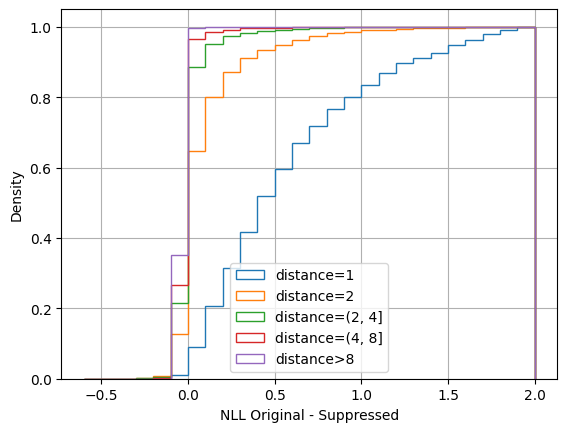

In [16]:
cumulative=True
bins = np.linspace(-0.6, 2, 27)
supp_sentence_df[supp_sentence_df['distance'] == 1]['nll_changes_t1'].hist(bins=bins, label = 'distance=1', density=True, histtype='step', cumulative=cumulative)
supp_sentence_df[supp_sentence_df['distance'] == 2]['nll_changes_t1'].hist(bins=bins, label = 'distance=2', density=True, histtype='step', cumulative=cumulative)
supp_sentence_df[(supp_sentence_df['distance'] > 2) & (supp_sentence_df['distance'] <= 4)]['nll_changes_t1'].hist(bins=bins, label = 'distance=(2, 4]', density=True, histtype='step', cumulative=cumulative)
supp_sentence_df[(supp_sentence_df['distance'] > 4) & (supp_sentence_df['distance'] <= 8)]['nll_changes_t1'].hist(bins=bins, label = 'distance=(4, 8]', density=True, histtype='step', cumulative=cumulative)

supp_sentence_df[(supp_sentence_df['distance'] > 8)]['nll_changes_t1'].hist(bins=bins, label = 'distance>8', density=True, histtype='step', cumulative=cumulative)

if not cumulative:
    plt.yscale('log')
plt.ylabel('Density')
plt.xlabel('NLL Original - Suppressed')
plt.legend()

## amplification

In [23]:
amp2_sentence_df = create_sentence_interaction_df(amp2_results)
amp5_sentence_df = create_sentence_interaction_df(amp5_results)
supp_sentence_df = create_sentence_interaction_df(supp_results)
joined_df = supp_sentence_df.merge(amp2_sentence_df, on=['problem_id', 'source_sentence_idx', 'target_sentence_idx', 'distance'], suffixes=('_supp', '_amp2'))
joined_df = joined_df.merge(amp5_sentence_df, on=['problem_id', 'source_sentence_idx', 'target_sentence_idx', 'distance'])
joined_df = joined_df.rename(columns={'nll_changes_t1': 'nll_changes_t1_amp5', 
                                      'kl_t1': 'kl_t1_amp5',
                                      'kl_t06': 'kl_t06_amp5',
                                      'tv_t1': 'tv_t1_amp5',
                                      'tv_t06': 'tv_t06_amp5'})

In [31]:
(joined_df['nll_changes_t1_supp'] < 0).mean()

np.float64(0.3080873539472017)

In [30]:
(joined_df['nll_changes_t1_amp2'] < 0).mean(), (joined_df['nll_changes_t1_amp5'] < 0).mean()

(np.float64(0.4522447547677285), np.float64(0.34238966253154934))

In [ ]:
joined_df[joined_df['distance']> 10][['nll_changes_t1_supp', 'nll_changes_t1_amp2', 'nll_changes_t1_amp5']].corr()

,nll_changes_t1_supp,nll_changes_t1_amp2
nll_changes_t1_supp,1.000000,-0.250248
nll_changes_t1_amp2,-0.250248,1.000000


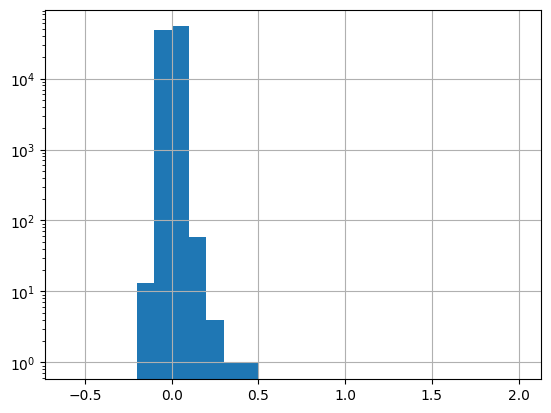

In [60]:
joined_df['nll_changes_t1_amp2'].hist(bins = np.linspace(-0.6, 2, 27))
plt.yscale('log')

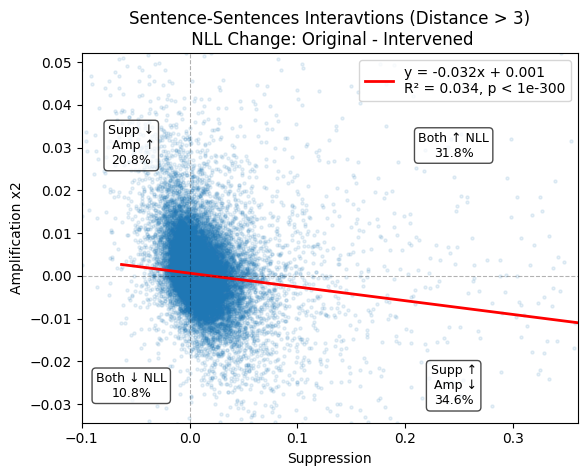

In [92]:
import numpy as np
from scipy import stats

plot_df = joined_df[joined_df['distance'] > 3]

# Calculate linear regression
mask = plot_df['nll_changes_t1_supp'].notna() & plot_df['nll_changes_t1_amp2'].notna()
x = plot_df.loc[mask, 'nll_changes_t1_supp']
y = plot_df.loc[mask, 'nll_changes_t1_amp2']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_squared = r_value**2

# Format p-value
if p_value == 0.0:
    p_text = "p < 1e-300"
elif p_value < 0.001:
    p_text = "p < 0.001"
else:
    p_text = f"p = {p_value:.3f}"

# Calculate quadrant percentages
q1 = ((x > 0) & (y > 0)).sum()  # Top-right: both increase NLL
q2 = ((x < 0) & (y > 0)).sum()  # Top-left: supp decreases, amp increases
q3 = ((x < 0) & (y < 0)).sum()  # Bottom-left: both decrease NLL
q4 = ((x > 0) & (y < 0)).sum()  # Bottom-right: supp increases, amp decreases
total = len(x)

# Create plot
plt.scatter(plot_df['nll_changes_t1_supp'], plot_df['nll_changes_t1_amp2'], alpha=0.1, s=5)

# Add trendline
x_line = np.array([plot_df['nll_changes_t1_supp'].quantile(0.001), 
                    plot_df['nll_changes_t1_supp'].quantile(0.999)])
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'r-', linewidth=2, 
         label=f'y = {slope:.3f}x + {intercept:.3f}\nR² = {r_squared:.3f}, {p_text}')

# Add quadrant lines
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
plt.xlim(-.1, plot_df['nll_changes_t1_supp'].quantile(0.999))
plt.ylim(plot_df['nll_changes_t1_amp2'].quantile(0.001), plot_df['nll_changes_t1_amp2'].quantile(0.999))
# Get axis limits for positioning text
xlim = plt.xlim()
ylim = plt.ylim()
x_pos = xlim[0] + (xlim[1] - xlim[0]) * 0.75  # 75% across
x_neg = xlim[0] + (xlim[1] - xlim[0]) * 0.1  # 25% across
y_pos = ylim[0] + (ylim[1] - ylim[0]) * 0.75  # 90% up
y_neg = ylim[0] + (ylim[1] - ylim[0]) * 0.10  # 10% up

# Add quadrant labels
plt.text(x_pos, y_pos, f'Both ↑ NLL\n{q1/total*100:.1f}%', 
         ha='center', va='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.text(x_neg, y_pos, f'Supp ↓\n Amp ↑\n{q2/total*100:.1f}%', 
         ha='center', va='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.text(x_neg, y_neg, f'Both ↓ NLL\n{q3/total*100:.1f}%', 
         ha='center', va='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.text(x_pos, y_neg, f'Supp ↑\n Amp ↓\n{q4/total*100:.1f}%', 
         ha='center', va='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


plt.xlabel('Suppression')
plt.ylabel('Amplification x2')
plt.title('Sentence-Sentences Interavtions (Distance > 3)\n NLL Change: Original - Intervened')
plt.legend()
plt.show()

## single sentance suppression vs cumulative suppression

In [96]:

cumm_sentence_df = create_sentence_interaction_df(cumm_supp_results)
supp_sentence_df = create_sentence_interaction_df(supp_results)
joined_df = supp_sentence_df.merge(cumm_sentence_df, on=['problem_id', 'source_sentence_idx', 'target_sentence_idx', 'distance'], suffixes=('_supp', '_cumm'))

In [98]:
problem_id = (330, True)	
target_sentence_idx = 24
plot_df = joined_df[(joined_df['problem_id'] == problem_id) & (joined_df['target_sentence_idx'] == target_sentence_idx)]

In [107]:
cumm_sentence_df.columns

Index(['problem_id', 'source_sentence_idx', 'target_sentence_idx', 'distance',
       'kl_t1', 'kl_t06', 'tv_t1', 'tv_t06', 'nll_changes_t1',
       'nll_changes_t06'],
      dtype='object')

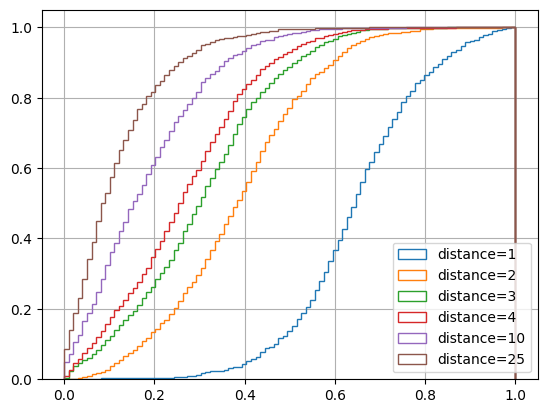

In [119]:
for d in [1,2,3,4, 10, 25]:
    cumm_sentence_df[cumm_sentence_df['distance'] == d]['tv_t1'].hist(label=f'distance={d}', density=True, histtype='step', cumulative=True, bins=np.linspace(0, 1, 100))

plt.legend()